<center><h1>Your Final Project</h1></center>

I'd like you to pull together two big ideas we have looked at in the last several weeks: word embeddings and ANNs. I'd like you to use the donorchoose.org data set. The goal is to predict whether an application will be successful or not. I am going to ask you to use only the `project_essay_2` column for doing prediction.

The approach I want you to take is to convert each entry in the `project_essay_2` column to a sentence vector by averaging the word vectors of the words in the essay. This will give you a sample size of 300.

I would then like you to train an ANN to use a nx300 training set where n is the size we choose to train on.

Finally, you will test on another set of mx300 to get your final accuracy.

##Let's get the table

I have modified the original table to have a more uniform distribution of accepts and rejects. I also shuffled it so you can skip that step.

In [0]:
import pandas as pd
#url = 'https://www.dropbox.com/s/ofjalkxqs0rtb97/train.csv?raw=1'
url = 'https://www.dropbox.com/s/fb4aj808j1mtwxg/donate_uniform.csv?raw=1'
shuffled_table = pd.read_csv(url, encoding='utf-8')

In [2]:
len(shuffled_table)  #it's a bit smaller

55468

In [3]:
shuffled_table.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p008074,977101b441d8624595f731b6bb25a3c9,Mrs.,WI,2016-09-23 15:10:36,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",An Easel for Early Learners,The learners in my class this year come from a...,This easel will provide a place to learn for y...,NaN,NaN,My students need an easel to use during carpet...,11,1
1,p043871,fa7f9115dd0344fbf613d13f1e6e7c33,Mrs.,CT,2016-08-01 15:05:58,Grades PreK-2,Health & Sports,"Gym & Fitness, Health & Wellness",Namaste-ing at School!,"I teach in a diverse science magnet school, wh...",These yoga materials will give my students the...,NaN,NaN,My students need an opportunity to unwind duri...,69,0
2,p028140,3b8c3e758318f86437efaccfe3f04ab8,Mrs.,PA,2017-03-24 12:54:34,Grades 6-8,Special Needs,Special Needs,Flexible Seating: Flexible Workplace,The typical school chairs just aren't comforta...,"As adults in the workplace, we have some flexi...",NaN,NaN,My students need to build the skills necessary...,1,0
3,p155310,1d286ff10ee3982b2b47813f1e415ef2,Ms.,CA,2016-08-26 00:08:16,Grades 3-5,Literacy & Language,"Literacy, Literature & Writing",Captivating Readers with Graphic Nonfiction,Can I keep reading? Please? I really don't wan...,My students love independent reading time beca...,NaN,NaN,My students need history and biography graphic...,50,1
4,p137236,4024d231df51084915d024965640602c,Mrs.,CO,2017-01-07 18:38:51,Grades 3-5,Math & Science,Mathematics,Mrs. Smith's Sharp Students Seeking Support!,We are a fun loving group of 8 and 9 year olds...,We would like to use these Kindles to help us ...,NaN,NaN,My students need more technology to help with ...,0,1


##Bring in your library now

You need the functions you defined in part A.

In [4]:
#flush the old directory
!rm -r  'uo_puddles'

rm: cannot remove 'uo_puddles': No such file or directory


In [0]:
my_github_name = 'FutureDeus'  #replace with your account name

In [0]:
#clone_url = f'https://github.com/{my_github_name}/w20_ds_library.git'
clone_url = f'https://github.com/{my_github_name}/uo_puddles.git'

In [7]:
#get the latest.
!git clone $clone_url 


Cloning into 'uo_puddles'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 153 (delta 85), reused 64 (delta 33), pack-reused 0
Receiving objects: 100% (153/153), 39.15 KiB | 466.00 KiB/s, done.
Resolving deltas: 100% (85/85), done.


In [0]:
from uo_puddles.uo_spacy import *  #I created a separate file for my spacy related functions

##Bring in spacy pieces

In [0]:
import spacy

In [10]:
!python -m spacy download en_core_web_md


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
import en_core_web_md
nlp = en_core_web_md.load()  

##It's still too big

It took me an hour just to find the meanv for all 55K rows. My worry is that this will also show up even more pronounced when we start running keras models and doing grid-search. So I am going to trim the table to one that is more practical for the final project running on colab. In real life and on your job, you could tell your boss you are going to have to move this to a paid cloud service (e.g., AWS) and it will cost money to suck in all the computing resources you need.

In [0]:
project_table = shuffled_table[:10000]  #grad first ten thousand rows as our working table

In [13]:
project_table['project_is_approved'].tolist().count(1)  #5057 - roughly half as we expect

5057

Pull out the sentences in raw form to make things a little faster.

In [0]:
essays = project_table['project_essay_2'].tolist()

In [0]:
labels = project_table['project_is_approved'].tolist()  #and the labels

#Challenge 1: Compute meanv for each summary in `essays`

Store results in `essay_vectors`.

In [16]:
#4 minutes

%%time

#your code
essay_vectors = np.array([sent2vec(nlp, i) for i in essays])


CPU times: user 3min 43s, sys: 1.17 s, total: 3min 44s
Wall time: 3min 44s


Just to make sure you match.

In [17]:
for i,v in enumerate(essay_vectors[:10]):
  print(i, v[:4])

0 [-0.0060167   0.17285353 -0.11974075 -0.01188554]
1 [ 0.0246392   0.14702731 -0.13826618  0.0214094 ]
2 [ 0.00330088  0.13333844 -0.18127029 -0.05487213]
3 [-0.06128987  0.13572565 -0.13230404 -0.0609788 ]
4 [-0.07406962  0.1693719  -0.16857849  0.00742364]
5 [-0.05211593  0.12453701 -0.111131   -0.0496376 ]
6 [-0.06303553  0.1303735  -0.10711763 -0.01191945]
7 [-0.00434586  0.11369805 -0.13297927 -0.00374848]
8 [-0.02671322  0.09711429 -0.13609868 -0.06690696]
9 [-0.03634059  0.09179693 -0.1541299  -0.03657126]


<pre>
0 [-0.0060167   0.17285353 -0.11974075 -0.01188554]
1 [ 0.0246392   0.14702731 -0.13826618  0.0214094 ]
2 [ 0.00330088  0.13333844 -0.18127029 -0.05487213]
3 [-0.06128987  0.13572565 -0.13230404 -0.0609788 ]
4 [-0.07406962  0.1693719  -0.16857849  0.00742364]
5 [-0.05211593  0.12453701 -0.111131   -0.0496376 ]
6 [-0.06303553  0.1303735  -0.10711763 -0.01191945]
7 [-0.00434586  0.11369805 -0.13297927 -0.00374848]
8 [-0.02671322  0.09711429 -0.13609868 -0.06690696]
9 [-0.03634059  0.09179693 -0.1541299  -0.03657126]
</pre>

In [18]:
len(set([tuple(v.tolist()) for v in essay_vectors])) #how many are different - 9998. So only 2 are duplicates.

9998

##Save if you want

Following code worked for me.

<pre>
from google.colab import drive
drive.mount('/content/gdrive')

path = '...'  #some place on your drive

np.save(path, essay_vectors)  #this saves it

vectors2 = np.load(path)  #load it back in

np.array_equal(vectors2, essay_vectors)  #True
</pre>

##Set up training and testing sets

I'll do this for you so you can compare against my results.

In [19]:
X_train = essay_vectors[:7000]
Y_train = labels[:7000]
print(Y_train[:20])  #[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0]

[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0]


In [20]:
X_test = essay_vectors[7000:]
Y_test = labels[7000:]
print(Y_test[:20])  #[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]


##What we need to beat

We can get this score just by always guessing 1 in the test set.

In [21]:
Y_test.count(1)/len(Y_test)  #0.5

0.5

#Challenge 2: Think you are good to go

Set up and train your model. Use grid-search to explore options. See if you can beat my best score of **0.6456666666666667** on `X_test`.

##What I want to see

I want to see you doing a diligent grid-search modeled after module 9.

In [22]:

### WRANGLE ###
from sklearn.preprocessing import minmax_scale

### PREREQUISITE ###

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found - turn it on under Runtime')
print('Found GPU at: {}'.format(device_name))
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import plot_model
from numpy.random import seed
rsgen = np.random.RandomState(1234)
set_random_seed = tf.random.set_seed
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10,8

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

def create_model(input_dim=300, lyrs=(8,), act='relu', opt='Nadam', dr=0.0):
    
    # set random seed for reproducibility
    seed(1234)
    set_random_seed(1234)
    
    model = Sequential()
    
    # create first hidden layer - must be at least one
    model.add(Dense(units=lyrs[0], input_dim=input_dim, activation=act))
    
    # create additional hidden layers - can be none
    for i in range(1,len(lyrs)):
        model.add(Dense(units=lyrs[i], activation=act))
    
    # add dropout, default is none
    if dr>0 : model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(units=1, activation='sigmoid'))  # output layer will always have sigmoid as activation to give us 0-1 range
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])  #have to change metrics to acc for grid-search
    
    return model

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [23]:
### GRID SEARCH ###

from sklearn.model_selection import GridSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [30, 60, 90]  #starting with just a few choices
epochs = [50, 100, 150, 200]    #ditto

#use this to override our defaults. keys must match create_model args
param_grid = dict(batch_size=batch_size, epochs=epochs)

# buld the search grid
grid = GridSearchCV(estimator=model,   #we created model above
                    param_grid=param_grid,
                    cv=3,  #use 3 folds for cross-validation
                    verbose=2)  # include n_jobs=-1 if you are using CPU

grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] batch_size=30, epochs=50 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... batch_size=30, epochs=50, total=  23.6s
[CV] batch_size=30, epochs=50 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


[CV] ......................... batch_size=30, epochs=50, total=  22.8s
[CV] batch_size=30, epochs=50 ........................................
[CV] ......................... batch_size=30, epochs=50, total=  23.1s
[CV] batch_size=30, epochs=100 .......................................
[CV] ........................ batch_size=30, epochs=100, total=  45.3s
[CV] batch_size=30, epochs=100 .......................................
[CV] ........................ batch_size=30, epochs=100, total=  46.0s
[CV] batch_size=30, epochs=100 .......................................
[CV] ........................ batch_size=30, epochs=100, total=  44.9s
[CV] batch_size=30, epochs=150 .......................................
[CV] ........................ batch_size=30, epochs=150, total= 1.1min
[CV] batch_size=30, epochs=150 .......................................
[CV] ........................ batch_size=30, epochs=150, total= 1.1min
[CV] batch_size=30, epochs=150 .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 21.1min finished


Best: 0.640858 using {'batch_size': 30, 'epochs': 100}
0.638287 (0.006826) with: {'batch_size': 30, 'epochs': 50}
0.640858 (0.005717) with: {'batch_size': 30, 'epochs': 100}
0.627571 (0.013220) with: {'batch_size': 30, 'epochs': 150}
0.630144 (0.005455) with: {'batch_size': 30, 'epochs': 200}
0.635715 (0.005898) with: {'batch_size': 60, 'epochs': 50}
0.639287 (0.006668) with: {'batch_size': 60, 'epochs': 100}
0.636286 (0.008840) with: {'batch_size': 60, 'epochs': 150}
0.633287 (0.006281) with: {'batch_size': 60, 'epochs': 200}
0.637572 (0.005887) with: {'batch_size': 90, 'epochs': 50}
0.638715 (0.006070) with: {'batch_size': 90, 'epochs': 100}
0.635715 (0.008459) with: {'batch_size': 90, 'epochs': 150}
0.633144 (0.006820) with: {'batch_size': 90, 'epochs': 200}


In [24]:
### OPTIMISE ###

batch_size = 30
epochs = 100

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
param_grid = dict(opt=optimizer)

# set up the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2, cv=3)

grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] opt=SGD .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................................... opt=SGD, total=  35.1s
[CV] opt=SGD .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.1s remaining:    0.0s


[CV] .......................................... opt=SGD, total=  35.1s
[CV] opt=SGD .........................................................
[CV] .......................................... opt=SGD, total=  34.8s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=  39.0s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=  39.0s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=  38.9s
[CV] opt=Adagrad .....................................................
[CV] ...................................... opt=Adagrad, total=  35.7s
[CV] opt=Adagrad .....................................................
[CV] ...................................... opt=Adagrad, total=  35.9s
[CV] opt=Adagrad .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 11.4min finished


Best: 0.642001 using {'opt': 'Adam'}
0.623428 (0.004292) with: {'opt': 'SGD'}
0.642001 (0.004017) with: {'opt': 'RMSprop'}
0.610286 (0.005214) with: {'opt': 'Adagrad'}
0.504142 (0.010082) with: {'opt': 'Adadelta'}
0.642001 (0.004704) with: {'opt': 'Adam'}
0.640858 (0.005717) with: {'opt': 'Nadam'}


In [25]:
### HIDDEN LAYERS ###

# create model
model = KerasClassifier(build_fn=create_model,
                        epochs=epochs, batch_size=batch_size, verbose=0)

# define the grid search parameters
layers = ((8,),(10,),(10,5),(12,6),(12,8,4), (16, 8), (20, 10))  #try 5 different layers
opt = ['Adam']  #best choice from previous search
param_grid = dict(lyrs=layers, opt=opt)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2, cv=3)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] lyrs=(8,), opt=Adam .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. lyrs=(8,), opt=Adam, total=  36.7s
[CV] lyrs=(8,), opt=Adam .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.7s remaining:    0.0s


[CV] .............................. lyrs=(8,), opt=Adam, total=  36.4s
[CV] lyrs=(8,), opt=Adam .............................................
[CV] .............................. lyrs=(8,), opt=Adam, total=  36.4s
[CV] lyrs=(10,), opt=Adam ............................................
[CV] ............................. lyrs=(10,), opt=Adam, total=  36.6s
[CV] lyrs=(10,), opt=Adam ............................................
[CV] ............................. lyrs=(10,), opt=Adam, total=  36.5s
[CV] lyrs=(10,), opt=Adam ............................................
[CV] ............................. lyrs=(10,), opt=Adam, total=  36.5s
[CV] lyrs=(10, 5), opt=Adam ..........................................
[CV] ........................... lyrs=(10, 5), opt=Adam, total=  37.9s
[CV] lyrs=(10, 5), opt=Adam ..........................................
[CV] ........................... lyrs=(10, 5), opt=Adam, total=  38.5s
[CV] lyrs=(10, 5), opt=Adam ..........................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 13.3min finished


Best: 0.643572 using {'lyrs': (10,), 'opt': 'Adam'}
0.642001 (0.004704) with: {'lyrs': (8,), 'opt': 'Adam'}
0.643572 (0.006552) with: {'lyrs': (10,), 'opt': 'Adam'}
0.630858 (0.008376) with: {'lyrs': (10, 5), 'opt': 'Adam'}
0.631716 (0.009627) with: {'lyrs': (12, 6), 'opt': 'Adam'}
0.619575 (0.016236) with: {'lyrs': (12, 8, 4), 'opt': 'Adam'}
0.630714 (0.004993) with: {'lyrs': (16, 8), 'opt': 'Adam'}
0.630572 (0.005563) with: {'lyrs': (20, 10), 'opt': 'Adam'}


In [26]:
#DROPOUT

model = KerasClassifier(build_fn=create_model, 
                        epochs=epochs, batch_size=batch_size, verbose=0)

# define the grid search parameters
layers = ((10,),)
opt = ['Adam']  #from previous
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
param_grid = dict(dr=drops, opt=opt, lyrs=layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] dr=0.0, lyrs=(10,), opt=Adam ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... dr=0.0, lyrs=(10,), opt=Adam, total=  36.7s
[CV] dr=0.0, lyrs=(10,), opt=Adam ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.7s remaining:    0.0s


[CV] ..................... dr=0.0, lyrs=(10,), opt=Adam, total=  36.5s
[CV] dr=0.0, lyrs=(10,), opt=Adam ....................................
[CV] ..................... dr=0.0, lyrs=(10,), opt=Adam, total=  37.2s
[CV] dr=0.01, lyrs=(10,), opt=Adam ...................................
[CV] .................... dr=0.01, lyrs=(10,), opt=Adam, total=  37.4s
[CV] dr=0.01, lyrs=(10,), opt=Adam ...................................
[CV] .................... dr=0.01, lyrs=(10,), opt=Adam, total=  37.4s
[CV] dr=0.01, lyrs=(10,), opt=Adam ...................................
[CV] .................... dr=0.01, lyrs=(10,), opt=Adam, total=  37.2s
[CV] dr=0.05, lyrs=(10,), opt=Adam ...................................
[CV] .................... dr=0.05, lyrs=(10,), opt=Adam, total=  37.8s
[CV] dr=0.05, lyrs=(10,), opt=Adam ...................................
[CV] .................... dr=0.05, lyrs=(10,), opt=Adam, total=  37.4s
[CV] dr=0.05, lyrs=(10,), opt=Adam ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 11.4min finished


Best: 0.643572 using {'dr': 0.0, 'lyrs': (10,), 'opt': 'Adam'}
0.643572 (0.006552) with: {'dr': 0.0, 'lyrs': (10,), 'opt': 'Adam'}
0.641716 (0.008761) with: {'dr': 0.01, 'lyrs': (10,), 'opt': 'Adam'}
0.637429 (0.004912) with: {'dr': 0.05, 'lyrs': (10,), 'opt': 'Adam'}
0.636144 (0.006122) with: {'dr': 0.1, 'lyrs': (10,), 'opt': 'Adam'}
0.639144 (0.004185) with: {'dr': 0.2, 'lyrs': (10,), 'opt': 'Adam'}
0.637430 (0.006609) with: {'dr': 0.5, 'lyrs': (10,), 'opt': 'Adam'}


Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_212 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_213 (Dense)            (None, 1)                 11        
Total params: 3,021
Trainable params: 3,021
Non-trainable params: 0
_________________________________________________________________
None
7000/7000 [==============================] - 0s 59us/sample - loss: 0.5994 - acc: 0.6737

acc: 67.37%


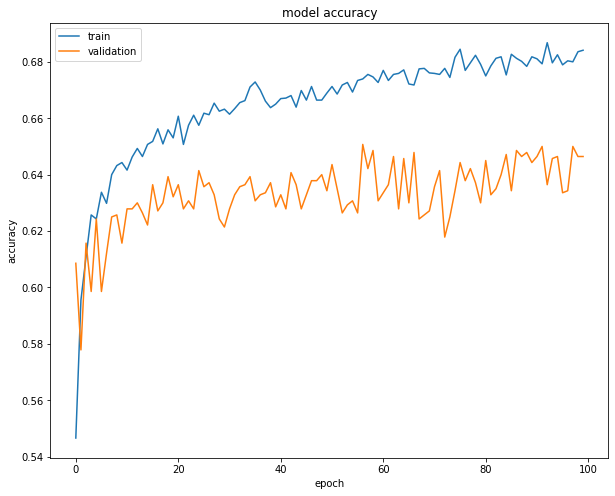

0.6466666666666666

In [27]:
# Train
model = create_model(lyrs=(10,), dr=0.0, opt='Adam')

print(model.summary())

# train model on full train set, with 80/20 validation split
training = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
                     validation_split=0.2,
                     verbose=0)

# evaluate the model
scores = model.evaluate(X_train, Y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# calculate predictions
raw_predictions = model.predict(X_test)
predictions = [int(round(x[0])) for x in raw_predictions]
cases = list(zip(predictions, Y_test))

(cases.count((0,0)) + cases.count((1,1)))/len(X_test)  #0.6456666666666667